In [1]:
import codecs

import pandas as pd
import seaborn as sns
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import nltk
from wordcloud import WordCloud
import matplotlib.pyplot as plt

ROOT_DIR = "."


In [ ]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/avowinkel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def bow2doc(bow, dictionary):
    return " ".join([dictionary[x[0]] for x in bow])


# Data Cleaning

In [ ]:
df_raw = pd.read_parquet(f"{ROOT_DIR}/data/cards.parquet")

In [ ]:
_columns = ["colors", "flavorText", "name"]

df = df_raw[_columns].copy()

# remove cards with no flavor text
df = df[df["flavorText"].notnull()]
df = df[df["flavorText"].apply(len) > 0]

# replace newline with spaces
df["flavorText"] = df["flavorText"].apply(lambda x: codecs.escape_decode(bytes(x, "utf-8"))[0].decode("utf-8"))

# set virtual color for cards without a color
df["colors"] = df["colors"].fillna("N")
df.loc[df["colors"] == "", "colors"] = "N"

# de-duplicate cards by "name"
df = df.drop_duplicates(subset="name")

# df.to_csv(f"{ROOT_DIR}/data/cards.csv", index=False)

df[_columns].head()

,colors,flavorText,name
1,W,"""The will of all, by my hand done.""",Ancestor's Chosen
2,W,Every tear shed is a drop of immortality.,Angel of Mercy
4,W,Only the warrior who can admit mortal weakness...,Angelic Blessing
6,W,The harmony of the glorious is a dirge to the ...,Angelic Chorus
7,W,"""The Ancestor protects us in ways we can't beg...",Angelic Wall


# Tokenizing

In [ ]:
# use a tokenizer to split the text into words
# by using space characters as separators
tokenizer = RegexpTokenizer(r'\w+')
en_stop = set(stopwords.words('english'))

def preprocess(text):
    tokens = tokenizer.tokenize(text.lower())
    cleaned_tokens = [i for i in tokens if not i in en_stop]
    return cleaned_tokens

# remove stopwords
df['cleaned_texts'] = df['flavorText'].apply(preprocess)


In [ ]:
pd.set_option('display.max_colwidth', None)
df.sample(10, random_state=42)

,colors,flavorText,name,cleaned_texts
42097,B,"""Your laws, like your bones, were made to be broken.""",Knight of Infamy,"[laws, like, bones, made, broken]"
6013,B,Greed and gluttony led him to death. Now they are his greatest assets.,Gluttonous Zombie,"[greed, gluttony, led, death, greatest, assets]"
34514,B,"""Let me give you a hand. He won't be needing it; he's left-handed. Also dead.""",Stitcher's Supplier,"[let, give, hand, needing, left, handed, also, dead]"
76581,U,"""Whoever Tezzeret is working with is after more than the Emperor.""\n—Tamiyo",Solve the Equation,"[whoever, tezzeret, working, emperor, tamiyo]"
12845,B,"""There are dark, ancient arts that fascinate even me.""\n—Sorin Markov",Ophiomancer,"[dark, ancient, arts, fascinate, even, sorin, markov]"
25554,R,"Anger is his greatest weapon, and he sharpens it daily.",Coalition Warbrute,"[anger, greatest, weapon, sharpens, daily]"
23341,W,The murdered inhabitants of Hollowhenge impart to the living the terror they felt in death.,Lingering Souls,"[murdered, inhabitants, hollowhenge, impart, living, terror, felt, death]"
79084,"B, W","""When your father is Dean Embrose, second best really isn't an option.""","Killian, Ink Duelist","[father, dean, embrose, second, best, really, option]"
8004,W,"""When I made my oath to Moradin, I left selfishness and cowardice behind. Every battle, I make that commitment anew.""",Steadfast Paladin,"[made, oath, moradin, left, selfishness, cowardice, behind, every, battle, make, commitment, anew]"
11620,R,Akki shells provided good protection when downhill charging became headlong tumbling.,Goblin Cohort,"[akki, shells, provided, good, protection, downhill, charging, became, headlong, tumbling]"


# Identify the most common words per color

In [ ]:
# assign a unique color to every row
# for multi-colored cards, replicate the row

df_colors = df["colors"].str.split(",", expand=True).stack().reset_index(level=1, drop=True).to_frame("color")
df_colors = df_colors.merge(df, left_index=True, right_index=True).reset_index()
df_colors["color"] = df_colors["color"].apply(str.strip)

colors = df_colors["color"].unique().tolist()

# collect all tokens of a color
color_tokens = df_colors.groupby("color")["cleaned_texts"].sum()

print("Most prevalent words in each color:")

dictionaries = {}

for color in colors:
    dictionaries[color] = corpora.Dictionary([color_tokens[color]])
    print(f"{color}: {dictionaries[color].most_common(10)}")

# corpus = [dictionary.doc2bow(text) for text in color_tokens]

Most prevalent words in each color:
W: [('one', 241), ('even', 139), ('light', 135), ('never', 122), ('life', 119), ('us', 114), ('every', 111), ('must', 108), ('world', 106), ('war', 105)]
U: [('one', 221), ('like', 126), ('time', 121), ('sea', 108), ('see', 105), ('even', 103), ('mind', 100), ('know', 93), ('never', 92), ('world', 91)]
B: [('death', 224), ('one', 223), ('life', 152), ('dead', 140), ('blood', 122), ('like', 104), ('never', 98), ('every', 87), ('would', 81), ('even', 74)]
R: [('one', 217), ('fire', 169), ('like', 136), ('never', 113), ('goblins', 104), ('way', 89), ('world', 86), ('every', 83), ('blood', 81), ('even', 81)]
G: [('one', 227), ('forest', 153), ('nature', 119), ('life', 117), ('world', 113), ('like', 112), ('never', 110), ('even', 109), ('every', 92), ('us', 91)]
N: [('one', 128), ('every', 80), ('power', 71), ('world', 69), ('never', 65), ('life', 64), ('even', 60), ('would', 54), ('urza', 53), ('like', 52)]


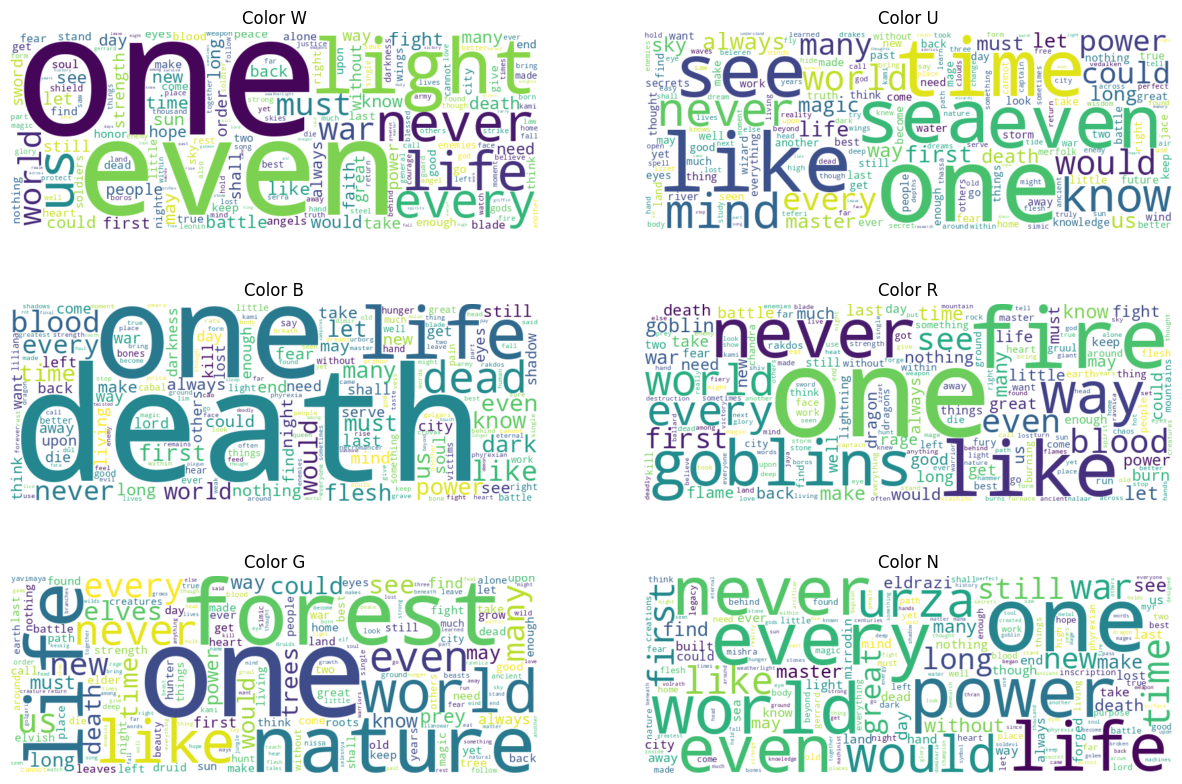

In [ ]:
# generating word cloud for each color
plt.subplots(3, 2, figsize=(15, 10))
for i, color in enumerate(colors):
    word_freq = pd.Series(color_tokens[color]).value_counts().to_dict()
    wordcloud = WordCloud(width=800, height=300, background_color ='white').generate_from_frequencies(word_freq)
    
    plt.subplot(3, 2, i + 1)
    plt.title('Color ' + str(color))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

plt.show()

# Build a topic model

In [ ]:
# creating the dictionary and corpus
dictionary = corpora.Dictionary(df['cleaned_texts'])
corpus = [dictionary.doc2bow(text) for text in df['cleaned_texts']]

# building the LDA model
num_topics = 6
ldamodel = LdaMulticore(corpus, num_topics=num_topics, id2word=dictionary, passes=15)


## Visualize the topics

In [ ]:
# viewing the topics
topics = ldamodel.print_topics(num_words=8)
for topic in topics:
    print(topic)

(0, '0.004*"time" + 0.004*"like" + 0.004*"many" + 0.004*"never" + 0.004*"make" + 0.003*"new" + 0.003*"us" + 0.003*"without"')
(1, '0.009*"one" + 0.005*"must" + 0.005*"world" + 0.005*"know" + 0.004*"like" + 0.004*"things" + 0.004*"even" + 0.004*"see"')
(2, '0.006*"never" + 0.006*"death" + 0.005*"one" + 0.005*"life" + 0.004*"nothing" + 0.004*"every" + 0.004*"even" + 0.004*"blood"')
(3, '0.006*"one" + 0.006*"long" + 0.005*"world" + 0.004*"life" + 0.004*"like" + 0.004*"let" + 0.004*"way" + 0.004*"nature"')
(4, '0.010*"one" + 0.005*"would" + 0.005*"many" + 0.004*"always" + 0.003*"mind" + 0.003*"first" + 0.003*"sea" + 0.003*"see"')
(5, '0.007*"one" + 0.006*"power" + 0.004*"may" + 0.004*"never" + 0.004*"know" + 0.003*"enough" + 0.003*"get" + 0.003*"right"')


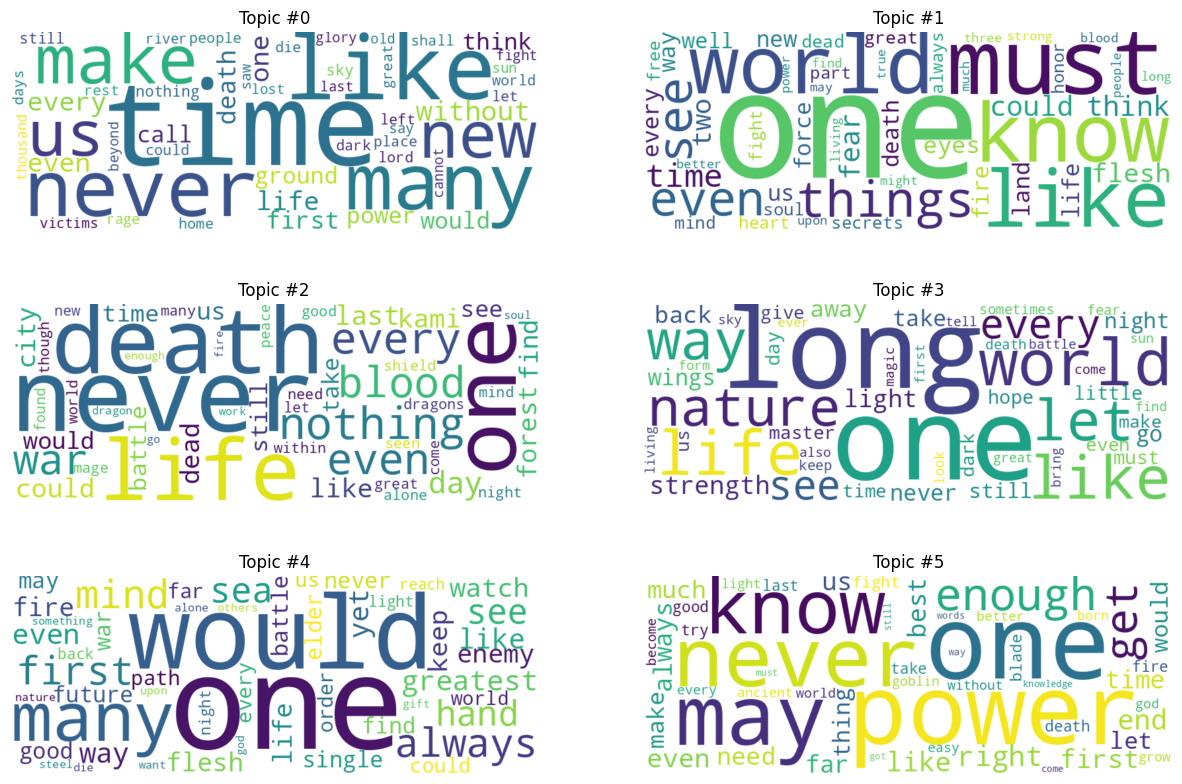

In [ ]:
# generating a word cloud for each topic
plt.subplots(3, 2, figsize=(15, 10))
for i, topic in enumerate(topics):
    word_freq = {k: v for (k,v) in ldamodel.show_topic(i, topn=50)}
    wordcloud = WordCloud(width=800, height=300, background_color ='white').generate_from_frequencies(word_freq)
    
    plt.subplot(3, 2, i + 1)
    plt.title('Topic #' + str(i))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

plt.show()

## Identify dominant topic of every card and compare

In [ ]:
# get the dominant topic for each document

dominant_topics = []

for c in corpus:
    dominant_topic = sorted(ldamodel[c], key=lambda x: x[1], reverse=True)[0][0]
    dominant_topics.append(dominant_topic)

df["dominant_topic"] = dominant_topics

df["num_colors"] = df["colors"].apply(lambda x: x.count(",") + 1)


In [ ]:
num_single_color = len(df[df["num_colors"] == 1])

print(f"{num_single_color} of {len(df)} ({num_single_color / len(df) * 100:.2f}%) cards are single-colored")


15889 of 17702 (89.76%) cards are single-colored


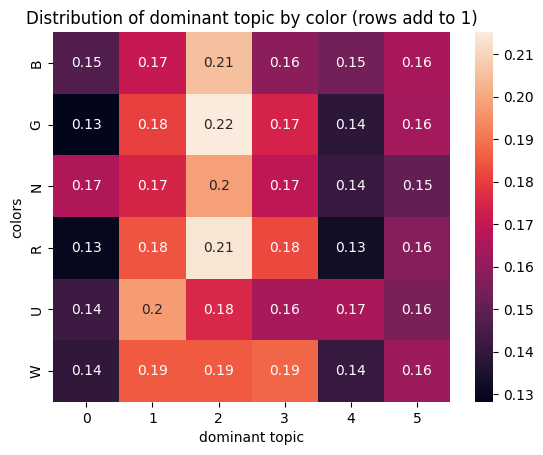

In [ ]:
# analyse for single-color cards
# print a correlation matrix between the dominant topic and the color

df_analyse = df[df["num_colors"] == 1].copy()

corr_counts = df_analyse.pivot_table(index="dominant_topic", columns="colors", values="num_colors", aggfunc="sum", fill_value=0)

# normalize the counts per color
corr_counts_bycolor = corr_counts.div(corr_counts.sum(axis=0), axis=1).T

# create a heatmap of that data
ax = sns.heatmap(corr_counts_bycolor, annot=True)
ax.set_title("Distribution of dominant topic by color (rows add to 1)")
ax.set_xlabel("dominant topic")

plt.show()